In [1]:
# from Algorithm 1: HMC, page1353
def Leapfrog(theta, r, eps, L):
    logp, grad = L(theta)
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde

In [2]:
def FindReasonableEpsilon(theta, L):
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime = Leapfrog(theta, r, eps, L)
    
    logp, grad = L(theta)
    logp_prime, grad_prime = L(theta_prime)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime = Leapfrog(theta, r, eps, L);
        logp_prime, grad_prime = L(theta_prime)
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [3]:
def BuildTree(theta, r, u, v, j, eps, esto0, L):
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime = Leapfrog(theta, r, v*eps, L)
        logp_prime, grad_prime = L(theta_prime)
        logp_0, grad0 = L(theta0)
        
        esto = logp_prime - 0.5 * np.dot(r_prime, r_prime)      

        n_prime = int(u <= np.exp(esto))   
        s_prime = int(esto > np.log(u) - 1000)
        alpha_prime = min(1, np.exp(esto - esto0))
                                                   
        return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree(theta, r, u, v, j-1, eps, esto0, L)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, _,_, theta_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_minus, r_minus, u, v, j-1, eps, esto0, L)
            else:
                _, _, theta_plus, r_plus, theta_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_plus, r_plus, u, v, j-1, eps, esto0, L)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [4]:
def nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6):
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    eps = FindReasonableEpsilon(theta0, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()
        logp, grad = L(samples[m-1,:])

        esto = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(esto), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0 
        
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_minus, r_minus, u, v_j, j, eps, esto, L)
            else:
                _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_plus, r_plus, u, v_j, j, eps, esto, L)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
            
        if m <= M_adapt:
            H_bar = (1 - 1/(m+t0))*H_bar + (1/(m+t0)) * (delta - alpha/n_alpha)
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            eps_bar = np.exp(m**(-k) * np.log(eps) + (1-m**(-k))*np.log(eps_bar))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    
    return samples, burned_in

In [5]:
#X = np.random.poisson(5, 100)
#N = 100
#def L(theta):
#    grad = sum(X) / theta - N
#    logp = sum(X)*np.log(theta) - theta*N
#    return logp, grad
#np.mean(X)

In [6]:
# simple example
#theta0 = np.array([10])
#M = 10000
#M_adapt = 1000
#samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6)
#np.mean(burned_in)

In [7]:
# multivariate normal
mean = np.ones(75)
cov = np.identity(75)
X = np.random.multivariate_normal(mean, cov, 100)

In [8]:
sample_mean = np.mean(X, axis = 0)

In [9]:
def L_MVN(theta):
    cumsum = 0
    grad = 0
    for x in X:
        cumsum += ((x - theta).T @ np.linalg.inv(cov)) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(cov) 
    logp = -0.5 * cumsum
    return logp, grad

In [10]:
#def L_MVN(theta):
#    cumsum = ((theta).T @ np.linalg.inv(cov)) @ (theta)
#    grad = (theta).T @ np.linalg.inv(cov) 
#    logp = -0.5 * cumsum
#    return logp, grad

In [11]:
%%time
# run for normal
theta0 = np.zeros(75)
M = 1000
M_adapt = 100

samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L_MVN, delta = 0.6)


CPU times: user 8min, sys: 4min 10s, total: 12min 10s
Wall time: 6min 49s


In [12]:
unique_samples = np.array([samples[0,:]])
# subset just accepted theta's
for i in range(1, M):
    if all(samples[i-1,:] != samples[i,:]):
        unique_samples = np.vstack([unique_samples, samples[i]])
        

In [13]:
np.mean(burned_in, axis = 0)

array([ -5.70373620e+09,  -5.82511873e+09,  -1.00344122e+10,
        -6.15638070e+09,  -7.95079055e+09,  -4.36941394e+09,
        -9.67950858e+09,  -6.13901747e+09,  -4.65140926e+09,
        -6.40202764e+09,  -7.09221266e+09,  -6.23897117e+09,
        -5.58827947e+09,  -8.65346781e+09,  -4.83179587e+09,
        -6.73473772e+09,  -4.69676811e+09,  -8.27964892e+09,
        -4.04288992e+09,  -4.16310954e+09,  -3.46678820e+09,
        -9.64969751e+09,  -5.95443424e+09,  -8.05274164e+09,
        -7.36915590e+09,  -2.98467352e+09,  -8.94444154e+09,
        -6.57739376e+09,  -3.50840381e+09,  -5.85430665e+09,
        -3.63655866e+09,  -7.16786654e+09,  -4.95690473e+09,
        -6.90243403e+09,  -5.54876703e+09,  -6.43571400e+09,
        -6.63133996e+09,  -3.42840592e+08,  -2.78210264e+09,
        -9.22563992e+09,  -6.52724827e+09,  -2.53221610e+09,
        -6.54226202e+09,  -5.43484712e+09,  -4.96543924e+09,
        -1.01373970e+10,  -7.86780569e+09,  -7.28786188e+09,
        -6.08436479e+09,

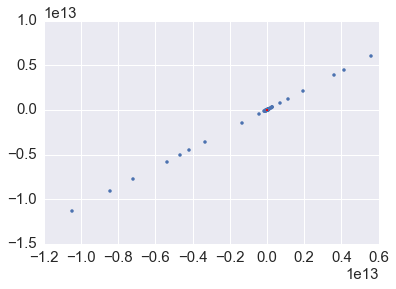

In [14]:
plt.plot(samples[1:M,0], samples[1:M,3], ".")
plt.plot(unique_samples[1:50,0], unique_samples[1:50,3], 'r')

In [106]:
import pymc3 as pm
import numpy.random as rng
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [107]:
niter = 7000
with pm.Model() as test_context:
    mu = pm.MvNormal('mu', 0, tau=cov, shape=5)
    y = pm.MvNormal('y', mu=mu, tau= cov, observed=X)
    step = pm.Metropolis()
    trace = pm.sample(niter,step=step)

 [-----------------100%-----------------] 7000 of 7000 complete in 0.8 sec

(7000, 5)

In [71]:
metropolis_samples = trace['mu']


In [140]:
unique_samples_met = np.array([metropolis_samples[0,:]])
# subset just accepted theta's
for i in range(1, niter):
    if all(metropolis_samples[i-1,:] != metropolis_samples[i,:]):
        unique_samples_met = np.vstack([unique_samples_met, metropolis_samples[i]])   

(2156, 5)

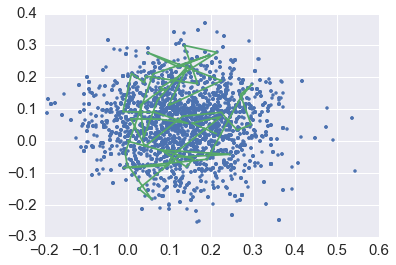

In [143]:
plt.plot(metropolis_samples[0:M,0], metropolis_samples[0:M,3], ".")
plt.plot(unique_samples_met[0:50,0], unique_samples_met[0:50,3], 'r')